In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

In [57]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [60]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [65]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CustomerID    200 non-null    object        
 1   CustomerName  200 non-null    object        
 2   Region        200 non-null    object        
 3   SignupDate    200 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 6.4+ KB


In [66]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   Price            1000 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 54.8+ KB


In [67]:
# Merge datasets on CustomerID
data = pd.merge(customers, transactions, on='CustomerID')

In [68]:
# Feature Engineering: Aggregate transaction data
customer_features = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spend
    'TransactionID': 'count',  # Frequency of purchases
    'TransactionDate': lambda x: (pd.Timestamp.now() - pd.to_datetime(x)).dt.days.min()  # Recency
}).reset_index()

customer_features.rename(columns={
    'TotalValue': 'TotalSpend',
    'TransactionID': 'PurchaseFrequency',
    'TransactionDate': 'Recency'
}, inplace=True)

In [69]:
customer_features

,CustomerID,TotalSpend,PurchaseFrequency,Recency
0,C0001,3354.52,5,91
1,C0002,1862.74,4,61
2,C0003,2725.38,4,161
3,C0004,5354.88,8,41
4,C0005,2034.24,3,90
...,...,...,...,...
194,C0196,4982.88,4,49
195,C0197,1928.65,3,36
196,C0198,931.83,2,120
197,C0199,1979.28,4,99


In [89]:
# Merge with customer profile data
final_data = pd.merge(customers, customer_features, on='CustomerID')

In [90]:
final_data

,CustomerID,CustomerName,Region,SignupDate,TotalSpend,PurchaseFrequency,Recency
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5,91
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4,61
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4,161
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8,41
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3,90
...,...,...,...,...,...,...,...
194,C0196,Laura Watts,Europe,2022-06-07,4982.88,4,49
195,C0197,Christina Harvey,Europe,2023-03-21,1928.65,3,36
196,C0198,Rebecca Ray,Europe,2022-02-27,931.83,2,120
197,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,4,99


In [91]:
# One-hot encoding region
final_data = pd.get_dummies(final_data, columns=['Region'], drop_first=True)

In [92]:
# Drop unnecessary columns
final_data.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1, inplace=True)
# Standard scaling the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(final_data)

In [94]:
scaled_data

array([[-0.06170143, -0.01145819, -0.26963951, -0.57928445, -0.54831888,
         1.54041597],
       [-0.87774353, -0.46749414, -0.69359208, -0.57928445, -0.54831888,
        -0.6491753 ],
       [-0.40585722, -0.46749414,  0.71958314, -0.57928445, -0.54831888,
         1.54041597],
       ...,
       [-1.38697529, -1.37956603,  0.1401813 ,  1.72626765, -0.54831888,
        -0.6491753 ],
       [-0.81399315, -0.46749414, -0.15658549,  1.72626765, -0.54831888,
        -0.6491753 ],
       [ 0.70636652, -0.01145819, -0.80664609, -0.57928445, -0.54831888,
        -0.6491753 ]])

In [93]:
# Determine optimal number of clusters using DB Index and Silhouette Score
db_scores = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    db_scores.append(davies_bouldin_score(scaled_data, labels))
    silhouette_scores.append(silhouette_score(scaled_data, labels))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

In [112]:
db_scores

[1.7315353787835916,
 1.5161429775406268,
 1.144632558427399,
 1.1583117074894447,
 1.106517549557335,
 1.0788823831472247,
 0.9408895599943772,
 1.0404735856201246,
 0.9759231624157941]

In [114]:
silhouette_scores

[0.21231375309037084,
 0.2980496221151577,
 0.33913511352335607,
 0.38145783709406855,
 0.33667001925285783,
 0.31958094720902347,
 0.3643830817761229,
 0.3298526307235703,
 0.35060005814239176]

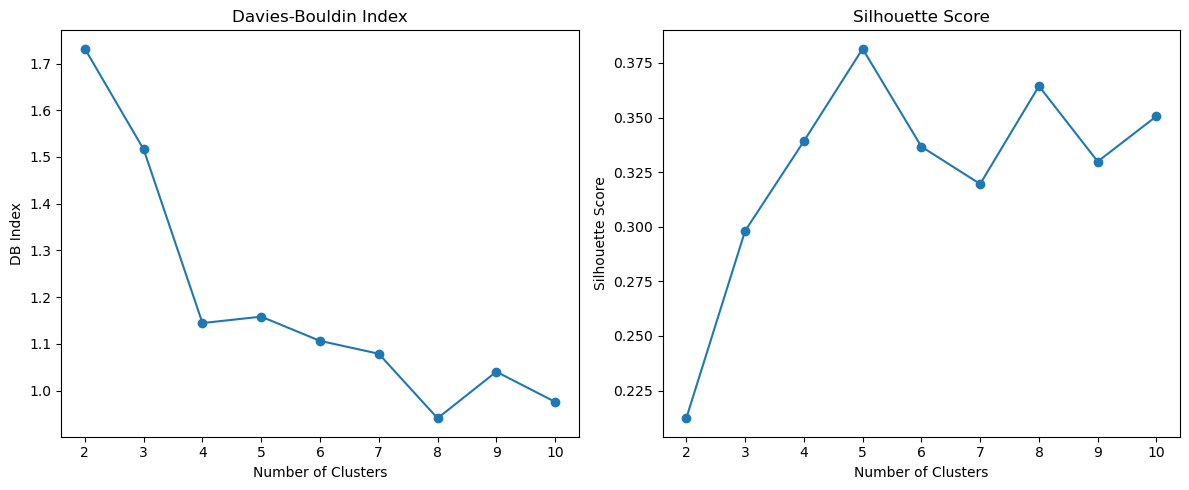

In [79]:
# Plot DB Index and Silhouette Score for different cluster numbers
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), db_scores, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

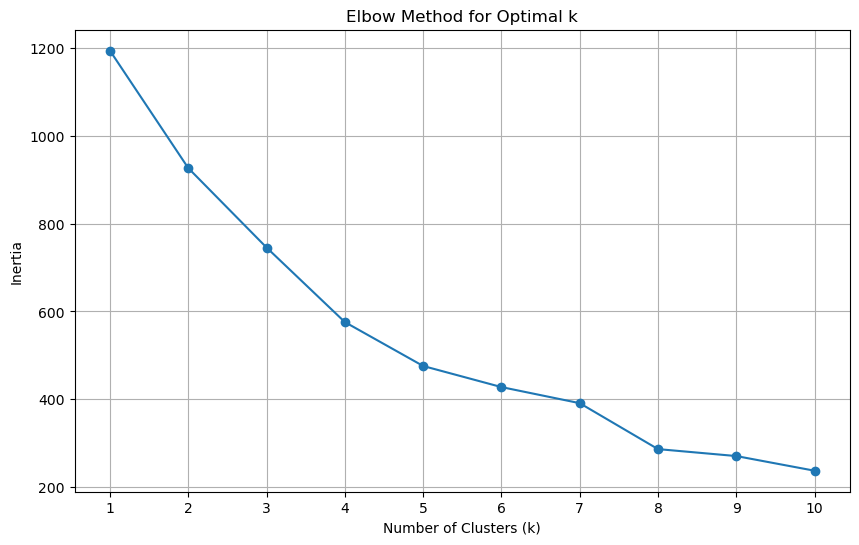

Clusters (k): 1, Inertia: 1194.0
Clusters (k): 2, Inertia: 926.5227742901528
Clusters (k): 3, Inertia: 745.5029415159132
Clusters (k): 4, Inertia: 575.6641296686715
Clusters (k): 5, Inertia: 475.6030121350176
Clusters (k): 6, Inertia: 427.56029675645283
Clusters (k): 7, Inertia: 390.8864957448439
Clusters (k): 8, Inertia: 286.20452725245815
Clusters (k): 9, Inertia: 270.3851967628164
Clusters (k): 10, Inertia: 236.95858580490233


In [80]:
inertias = []
k_values = range(1, 11)  # Testing 1-10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Print inertia values for reference
for k, inertia in zip(k_values, inertias):
    print(f"Clusters (k): {k}, Inertia: {inertia}")

In [126]:
# Optimal clustering with K=5 (based on above scores)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels = kmeans.fit_predict(scaled_data)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [127]:
# Add cluster labels to the dataset for interpretation
final_data['Cluster'] = labels

In [128]:
final_data

,TotalSpend,PurchaseFrequency,Recency,Region_Europe,Region_North America,Region_South America,Cluster
0,3354.52,5,91,False,False,True,1
1,1862.74,4,61,False,False,False,4
2,2725.38,4,161,False,False,True,1
3,5354.88,8,41,False,False,True,1
4,2034.24,3,90,False,False,False,4
...,...,...,...,...,...,...,...
194,4982.88,4,49,True,False,False,3
195,1928.65,3,36,True,False,False,3
196,931.83,2,120,True,False,False,3
197,1979.28,4,99,True,False,False,3


In [129]:
# PCA for visualization (reduce to 2 components)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_data)

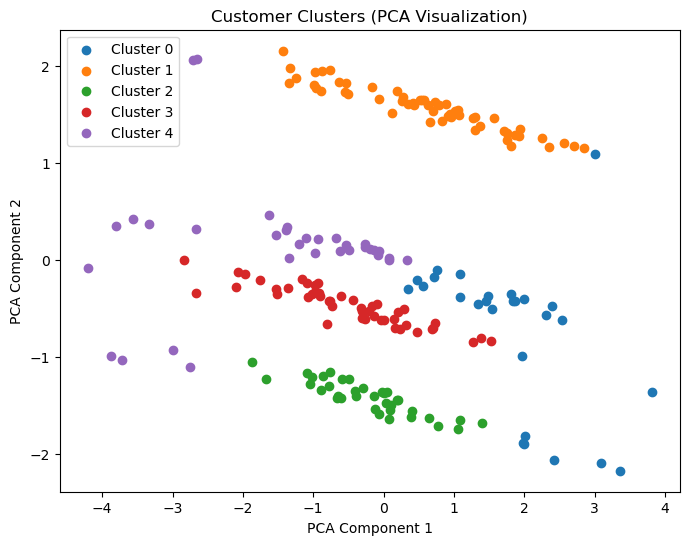

In [130]:
# Plot clusters
plt.figure(figsize=(8, 6))
for cluster in np.unique(labels):
    plt.scatter(pca_components[labels == cluster, 0], pca_components[labels == cluster, 1], label=f'Cluster {cluster}')
    
plt.title('Customer Clusters (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

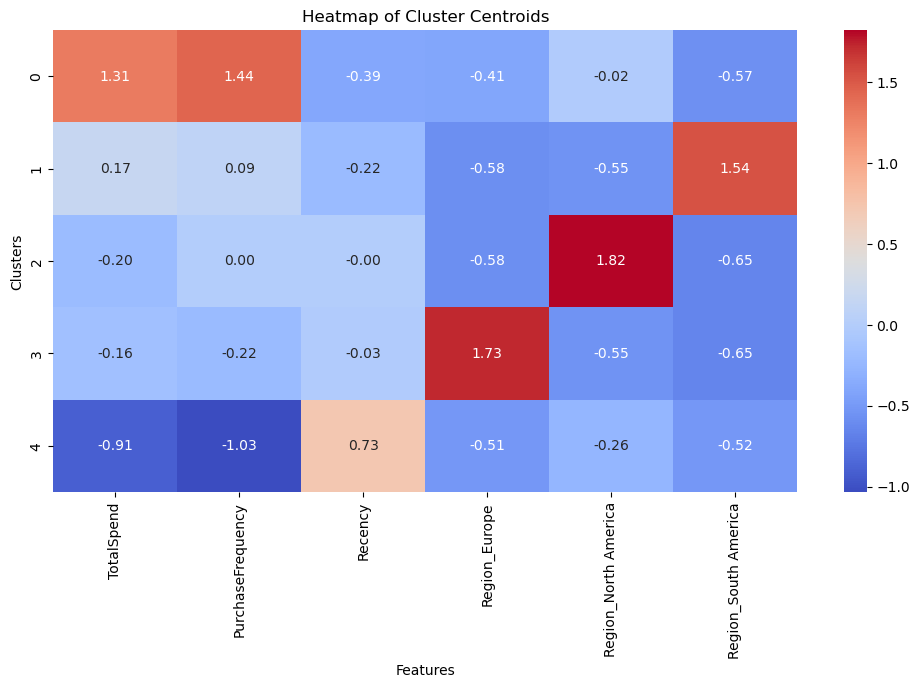

In [131]:

# Compute cluster centroids
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns=final_data.columns[:-1])  

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(centroid_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Cluster Centroids')
plt.xlabel('Features')
plt.ylabel('Clusters')
plt.show()

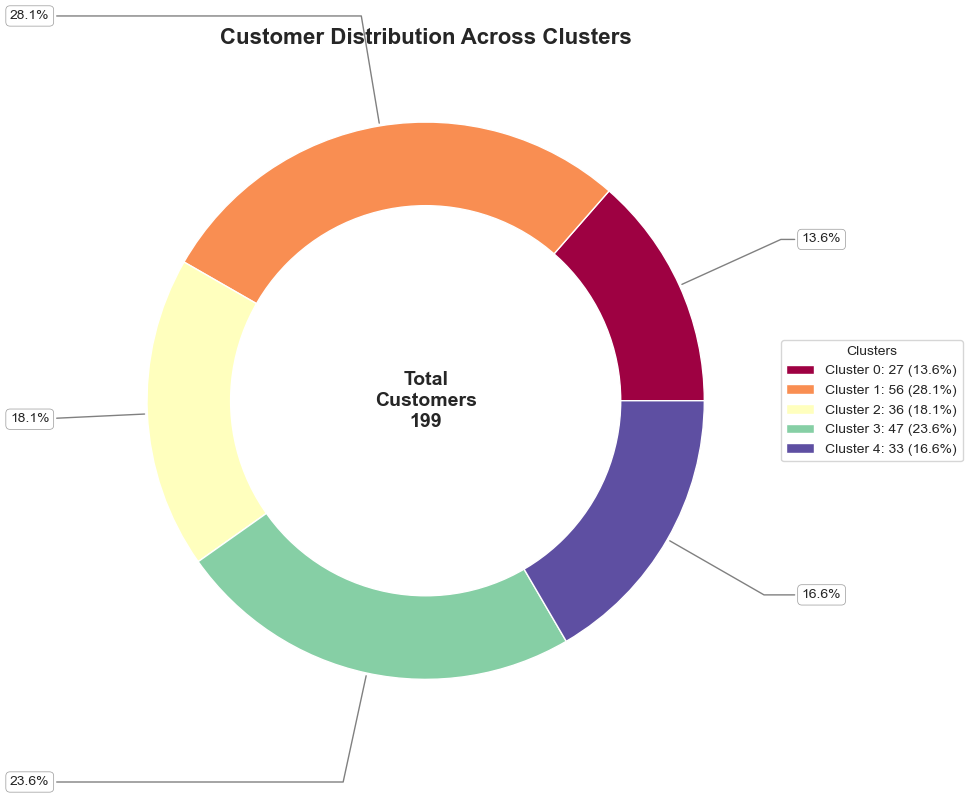

In [134]:
#Cluster Customer Distribution

cluster_counts = pd.Series(labels).value_counts().sort_index()
total = cluster_counts.sum()
percentages = cluster_counts / total * 100
colors = plt.cm.Spectral(np.linspace(0, 1, len(cluster_counts)))
fig, ax = plt.subplots(figsize=(12, 8))

wedges, texts, autotexts = ax.pie(cluster_counts, 
                                  autopct='',
                                  pctdistance=0.85, 
                                  colors=colors,
                                  wedgeprops=dict(width=0.5, edgecolor='white'))

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.title("Customer Distribution Across Clusters", fontsize=16, fontweight='bold')

#legend
legend_labels = [f'Cluster {i}: {count} ({percentage:.1f}%)' 
                 for i, (count, percentage) in enumerate(zip(cluster_counts, percentages))]
plt.legend(wedges, legend_labels, title="Clusters", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))


ax.text(0, 0, f'Total\nCustomers\n{total}', ha='center', va='center', fontsize=14, fontweight='bold')

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw = dict(xycoords='data', textcoords='data',
              arrowprops=dict(arrowstyle="-", color='gray', connectionstyle=connectionstyle),
              bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.5, alpha=0.8),
              zorder=0, va="center")
    ax.annotate(f'{percentages[i]:.1f}%', xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

plt.tight_layout()
plt.show()


In [136]:
cluster_counts

0    27
1    56
2    36
3    47
4    33
Name: count, dtype: int64